In [454]:
import os
import math
import mujoco
import numpy as np
import mediapy as media 
import matplotlib.pyplot as plt
import imageio.v3 as iio

In [455]:
ostrich_xml = """
<mujoco>
    <compiler angle="degree"/>
    <option><flag contact="enable"/></option>
    
    <worldbody>
        <camera name="world" pos="0 -22 10" euler="60 0 0"/>
        
        <!-- Ground -->
        <geom mass="0.1" name="ramp" type="plane" pos="0 0 0" size="50 10 0.1" euler="0 0 0" rgba="0.7 0.7 .9 1" />
        
        <!-- Ostrich -->
        <body name="ostrich" pos="0 0 {wheel_radius}">

            <camera name="body_cam" mode="track" pos="0 -10 8" euler="60 0 0"/>
            

            <!-- Rigid Body -->

            <body name="rigid_legs">
                <geom mass="0.1"  name="rolling_leg_1" type="box" size=".1 .1 {still_leg_z}" pos="{still_leg_x} -{still_leg_y} {still_leg_z}" rgba=".5 .2 .9 1" contype="0"/>
                <geom mass="0.5" name="wheel_1" type="sphere" size="{wheel_radius}" pos="{still_leg_x} -{still_leg_y} 0" friction="0" rgba=".2 .2 .5 1"/>
                
                <geom mass="0.1" name="rolling_leg_2" type="box" size=".1 .1 {still_leg_z}" pos="{still_leg_x} {still_leg_y} {still_leg_z}" rgba=".5 .2 .9 1" contype="0"/>
                <geom mass="0.5" name="wheel_2" type="sphere" size="{wheel_radius}" pos="{still_leg_x} {still_leg_y} 0" friction="0" rgba=".2 .2 .5 1"/>

            </body>
            
            <body name="body" pos="0 0 {body_height}">
                <geom mass="0.1" name="body" type="box" size="{body_length} {body_width} .1" pos="0 0 0" euler="0 0 0" rgba="0 1 0 1" contype="0"/>

                <!-- Leg 1 --> 
                
                <body name="l1" pos="{leg_x} -{leg_y} {leg_z}" axisangle="0 1 0 180">
                
                    <!-- Fixed Link -->
                    <geom mass="0.1" type="box" size="{fixed} {bar_width} .0005" pos="0 0 0" contype="1" rgba=".1 .1 .1 1"/>

                    
                    <!-- Four Bar 1, "Knee" -->
                    <body name="l1_b1_1" pos="{b1_1_b} 0 0" axisangle="0 1 0 95">
                        <joint name="j1_b1_1" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" range="-90 90" stiffness="0"/>
                        <geom mass="0.1" type="box" size="{b1_1} {bar_width} .0005" pos="{b1_1_pos} 0 0" rgba="1 0 0 1"/>

                        <body name="l1_b1_2" pos="{b1_2_b} 0 0" axisangle="0 1 0 95">
                            <joint name="j1_b1_2" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" range="-90 90" stiffness="0"/>
                            <geom mass="0.1" type="box" size="{b1_2} {bar_width} .0005" pos="{b1_2_pos} 0 0" rgba="1 .5 .7 1"/>

                            <body name="l1_b1_3" pos="{b1_3_b} 0 0" axisangle="0 1 0 95">
                                <joint name="j1_b1_3" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" range="-90 90" stiffness="0"/>
                                <geom mass="0.1" type="box" size="{b1_3} {bar_width} .0005" pos="{b1_3_pos} 0 0" rgba="1 0 1 1"/>

                                <body name="l1_b1_4" pos="{b1_4_b} 0 0" axisangle="0 1 0 95">
                                    <joint name="j1_b1_4" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" range="-90 90" stiffness="0"/>
                                    <geom mass="0.1" type="box" size="{b1_4} {bar_width} .0005" pos="{b1_4_pos} 0 0" rgba="0 1 0 1"/>

                                    
                                </body>   
                            </body> 

                            <!-- Four Bar 2, "Ankle" -->
                            <body name="l1_b2_1" pos="{b2_1_b} 0 0" axisangle="0 1 0 0">
                                <joint name="j1_b2_1" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" range="-90 90" stiffness="0"/>
                                <geom mass="0.1" type="box" size="{b2_1} {bar_width} .0005" pos="{b2_1_pos} 0 0" rgba="0.5 0.5 0.5 1"/>

                                <body name="l1_b2_2" pos="{b2_2_b} 0 0" axisangle="0 1 0 95">
                                    <joint name="j1_b2_2" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" range="-90 90" stiffness="0"/>
                                    <geom mass="0.1" type="box" size="{b2_2} {bar_width} .0005" pos="{b2_2_pos} 0 0" rgba="0 0.5 0.5 1"/>

                                    <body name="l1_b2_3" pos="{b2_3_b} 0 0" axisangle="0 1 0 95">
                                        <joint name="j1_b2_3" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" range="-90 90" stiffness="0"/>
                                        <geom mass="0.1" type="box" size="{b2_3} {bar_width} .0005" pos="{b2_3_pos} 0 0" rgba="0.5 0 0.5 1"/>

                                        <body name="l1_b2_4" pos="{b2_4_b} 0 0" axisangle="0 1 0 95">
                                            <joint name="j1_b2_4" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                                            <geom mass="0.1" type="box" size="{b2_4} {bar_width} .0005" pos="{b2_4_pos} 0 0" rgba="0 0.5 0.5 1"/>

                                                
                                        </body> 
                                    </body> 
                                </body> 
                            </body>  

                            <!-- Transfer -->
                            <body name="l1_t_1" pos="{t_1_b} 0 0" axisangle="0 1 0 0">
                                <joint name="j1_t_1" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                                <geom mass="0.1" type="box" size="{t_1} {bar_width} .0005" pos="{t_1_pos} 0 0" rgba="0 0.5 0 1"/>

                                <body name="l1_t_2" pos="{t_2_b} 0 0" axisangle="0 1 0 60">
                                    <joint name="j1_t_2" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" range="0 45" stiffness="0"/>
                                    <geom mass="0.1" type="box" size="{t_2} {bar_width} .0005" pos="{t_2_pos} 0 0" rgba="0.5 0 0 1"/>

                                    <body name="l1_t_3" pos="{t_3_b} 0 0" axisangle="0 1 0 100">
                                        <joint name="j1_t_3" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                                        <geom mass="0.1" type="box" size="{t_3} {bar_width} .0005" pos="{t_3_pos} 0 0" rgba="1 1 0 1"/>

                                            
                                    </body>  
                                </body>  
                            </body>  


                        </body>     
                    </body>
                    
                </body>

                <!-- Leg 2 --> 
                
                <body name="l2" pos="{leg_x} {leg_y} {leg_z}" axisangle="0 1 0 180">
                    <!-- Fixed Link -->
                    <geom mass="0.0001" type="box" size="{fixed} {bar_width} .0005" pos="0 0 0" rgba=".1 .1 .1 1"/>

                    
                    <!-- Four Bar 1, "Knee" -->
                    <body name="l2_b1_1" pos="{b1_1_b} 0 0" axisangle="0 1 0 95">
                        <joint name="j2_b1_1" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                        <geom mass="0.0001" type="box" size="{b1_1} {bar_width} .0005" pos="{b1_1_pos} 0 0" rgba="1 0 0 1"/>

                        <body name="l2_b1_2" pos="{b1_2_b} 0 0" axisangle="0 1 0 95">
                            <joint name="j2_b1_2" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                            <geom mass="0.0001" type="box" size="{b1_2} {bar_width} .0005" pos="{b1_2_pos} 0 0" rgba="1 .5 .7 1"/>

                            <body name="l2_b1_3" pos="{b1_3_b} 0 0" axisangle="0 1 0 95">
                                <joint name="j2_b1_3" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                                <geom mass="0.0001" type="box" size="{b1_3} {bar_width} .0005" pos="{b1_3_pos} 0 0" rgba="1 0 1 1"/>

                                <body name="l2_b1_4" pos="{b1_4_b} 0 0" axisangle="0 1 0 95">
                                    <joint name="j2_b1_4" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                                    <geom mass="0.0001" type="box" size="{b1_4} {bar_width} .0005" pos="{b1_4_pos} 0 0" rgba="0 1 0 1"/>

                                    
                                </body>   
                            </body> 

                            <!-- Four Bar 2, "Ankle" -->
                            <body name="l2_b2_1" pos="{b2_1_b} 0 0" axisangle="0 1 0 0">
                                <joint name="j2_b2_1" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                                <geom mass="0.0001" type="box" size="{b2_1} {bar_width} .0005" pos="{b2_1_pos} 0 0" rgba="0.5 0.5 0.5 1"/>

                                <body name="l2_b2_2" pos="{b2_2_b} 0 0" axisangle="0 1 0 95">
                                    <joint name="j2_b2_2" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                                    <geom mass="0.0001" type="box" size="{b2_2} {bar_width} .0005" pos="{b2_2_pos} 0 0" rgba="0 0.5 0.5 1"/>

                                    <body name="l2_b2_3" pos="{b2_3_b} 0 0" axisangle="0 1 0 95">
                                        <joint name="j2_b2_3" type="hinge" axis="0 1 0" pos="0 0 0" range="0 180" damping="0" stiffness="0"/>
                                        <geom mass="0.0001" type="box" size="{b2_3} {bar_width} .0005" pos="{b2_3_pos} 0 0" rgba="0.5 0 0.5 1"/>

                                        <body name="l2_b2_4" pos="{b2_4_b} 0 0" axisangle="0 1 0 95">
                                            <joint name="j2_b2_4" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                                            <geom mass="0.0001" type="box" size="{b2_4} {bar_width} .0005" pos="{b2_4_pos} 0 0" rgba="0 0.5 0.5 1"/>

                                                
                                        </body> 
                                    </body> 
                                </body> 
                            </body>  

                            <!-- Transfer -->
                            <body name="l2_t_1" pos="{t_1_b} 0 0" axisangle="0 1 0 0">
                                <joint name="j2_t_1" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                                <geom mass="0.0001" type="box" size="{t_1} {bar_width} .0005" pos="{t_1_pos} 0 0" rgba="0 0.5 0 1"/>

                                <body name="l2_t_2" pos="{t_2_b} 0 0" axisangle="0 1 0 60">
                                    <joint name="j2_t_2" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                                    <geom mass="0.0001" type="box" size="{t_2} {bar_width} .0005" pos="{t_2_pos} 0 0" rgba="0.5 0 0 1"/>

                                    <body name="l2_t_3" pos="{t_3_b} 0 0" axisangle="0 1 0 100">
                                        <joint name="j2_t_3" type="hinge" axis="0 1 0" pos="0 0 0" damping="0" stiffness="0"/>
                                        <geom mass="0.0001" type="box" size="{t_3} {bar_width} .0005" pos="{t_3_pos} 0 0" rgba="1 1 0 1"/>

                                            
                                    </body>  
                                </body>  
                            </body>  


                        </body>     
                    </body>

                </body>


                <!-- Knee Motors -->
                <body name="l1_knee_Servo" pos="{knee_servo_x} -{knee_servo_y} {knee_servo_z}">
                    <geom mass="0.01" type="box" size="{servo_length} {servo_width} {servo_height}" pos="0 0 0" rgba="0 0 1 1"/>

                    <body name="l1_knee_horn" pos="-{servo_length} -{servo_horn_pos} 0" axisangle="0 1 0 180">
                        <joint name="j1_ks_horn" type="hinge" axis="0 1 0" pos="-{horn_length} 0 0" damping="0" stiffness="0" range="-90 90"/>
                        <geom mass="0.001" type="box" size="{horn_length} {horn_width} {horn_height}" pos="0 0 0" rgba="1 1 1 1"/>

                        <body name="l1_ks_1" pos="{ks_1_b} 0 0" axisangle="0 1 0 -5">
                            <joint name="j1_ks_1" type="ball" damping="0.6"/>
                            <geom mass="0.001" type="box" size="{ks_1} .01 .01" pos="{ks_1_pos} 0 0" contype="1" rgba="1 1 0 1"/>

                            <body name="l1_ks_2" pos="{ks_2_b} 0 0" axisangle="0 1 0 -5">
                                <joint name="j1_ks_2" type="ball" damping="0.6"/>
                                <geom mass="0.001" type="box" size="{ks_2} .01 .01" pos="{ks_2_pos} 0 0" contype="1" rgba="1 1 0 1"/>

                                <body name="l1_ks_3" pos="{ks_3_b} 0 0" axisangle="0 1 0 -5">
                                    <joint name="j1_ks_3" type="ball" damping="0.6"/>
                                    <geom mass="0.001" type="box" size="{ks_3} .01 .01" pos="{ks_3_pos} 0 0" contype="1" rgba="1 1 0 1"/>

                                    <body name="l1_ks_4" pos="{ks_4_b} 0 0" axisangle="0 1 0 -5">
                                        <joint name="j1_ks_4" type="ball" damping="0.6"/>
                                        <geom mass="0.001" type="box" size="{ks_4} .01 .01" pos="{ks_4_pos} 0 0" contype="1" rgba="1 1 0 1"/>

                                        <body name="l1_ks_5" pos="{ks_5_b} 0 0" axisangle="0 1 0 -5">
                                            <joint name="j1_ks_5" type="ball" damping="0.6"/>
                                            <geom mass="0.001" type="box" size="{ks_5} .01 .01" pos="{ks_5_pos} 0 0" contype="1" rgba="1 1 0 1"/>

                                            <body name="l1_ks_6" pos="{ks_6_b} 0 0" axisangle="0 1 0 -5">
                                                <joint name="j2_ks_6" type="ball" damping="0.6"/>
                                                <geom mass="0.1" type="box" size="{ks_6} {bar_width} .0005" pos="{ks_6_pos} 0 0" rgba="0.5 0 0 1"/>

                                                
                                            
                                            </body>  
                                        </body> 
                                    </body>  
                                </body>  
                            </body>  
                        </body>  
                    </body>
                </body>

                <body name="l1_ankle_Servo" pos="{ankle_servo_x} -{ankle_servo_y} {ankle_servo_z}">
                    <geom mass="0.01" type="box" size="{servo_length} {servo_width} {servo_height}" pos="0 0 0" rgba="0 0 1 1"/>

                    <body name="l1_ankle_horn" pos="-{servo_length} -{servo_horn_pos} 0" axisangle="0 1 0 0">
                        <joint name="j1_as_horn" type="hinge" axis="0 1 0" pos="{horn_length} 0 0" damping="0" stiffness="0" range="-90 90"/>
                        <geom mass="0.001" type="box" size="{horn_length} {horn_width} {horn_height}" pos="0 0 0" rgba="1 1 1 1"/>

                        
                    </body>
                </body>

            </body>
                    
        </body>

    </worldbody>

    <equality>
        <weld name="l1_4bar_1" active="true" body1="l1" body2="l1_b1_4" relpose="-{weld_b1_pos} 0 0 1 0 0 0"/>
        <weld name="l1_4bar_2" active="true" body1="l1_b1_3" body2="l1_b2_4" relpose="{weld_b2_pos} 0 0 0 0 1 0"/>
        <weld name="l1_t" active="true" body1="l1_b2_1" body2="l1_t_3" relpose="{weld_t_pos} 0 0 0 0 1 0"/>

        <weld name="l1_ks" active="true" body1="l1_ks_6" body2="l1_t_2" relpose="0 0 0 1 0 0 0"/>
        
        <weld name="l2_4bar_1" active="true" body1="l2" body2="l2_b1_4" relpose="-{weld_b1_pos} 0 0 1 0 0 0"/>
        <weld name="l2_4bar_2" active="true" body1="l2_b1_3" body2="l2_b2_4" relpose="{weld_b2_pos} 0 0 0 0 1 0"/>
        <weld name="l2_t" active="true" body1="l2_b2_1" body2="l2_t_3" relpose="{weld_t_pos} 0 0 0 0 1 0"/>


    </equality>

    <actuator>
        <position name="servo_1" joint="j1_ks_horn" kp="200"/>
    </actuator>

</mujoco>

"""

In [456]:
#        <weld name="l1_ks" active="true" body1="l1_ks_6" body2="l1_t_2" relpose="0 0 0 0 0 1 0"/>

duration = 15
framerate = 30 
data_rate = 100

# Default gait offsets
off_set_between_legs = math.pi/3

p1_off = math.pi/4
p2_off = math.pi/3
p3_off = math.pi/4 + off_set_between_legs
p4_off = math.pi/3 + off_set_between_legs


# Cosine amplitudes
A = 1.52 # 90 degrees radian 180 degrees total movement
f = .5

def runXML(xml, control=True, offset=None, render=True, fixed=True):
    
    model = mujoco.MjModel.from_xml_string(xml)
    data = mujoco.MjData(model)
    renderer = mujoco.Renderer(model)

    main_body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, 'body')

    off_set_between_legs = math.pi/3
    default_offsets = [
        math.pi/4,
        math.pi/3,
        math.pi/4 + off_set_between_legs,
        math.pi/3 + off_set_between_legs
    ]
    
    # Use provided offsets if available, otherwise use defaults
    p1_off, p2_off, p3_off, p4_off = offset if offset is not None else default_offsets
        

    def my_multi_controller(model, data):
        t = data.time 

        if t > 2:
            pos1 = A*math.cos(2*math.pi*f*t + p1_off)
            pos2 = A*math.cos(2*math.pi*f*t + p2_off)
            pos3 = A*math.cos(2*math.pi*f*t + p3_off)
            pos4 = A*math.cos(2*math.pi*f*t + p4_off)
            
            #data.ctrl[:] = [pos1, pos2, pos3, pos4]
            data.ctrl[:] = [pos1]    
        return

    try:
        if control:
            mujoco.set_mjcb_control(my_multi_controller)
        
        frames = []
        frames_body = []
    
        x = []
        t = []    
    
        mujoco.mj_resetData(model, data)
        
        while data.time < duration:
                    
            ####### Modeling
            mujoco.mj_step(model, data)
            
            
            if len(x) < data.time * data_rate:
                t.append(data.time)
                x.append(data.xpos[main_body_id][0].copy())     
            if render:
                if len(frames) < data.time * framerate:
                    if fixed:
                        renderer.update_scene(data, "world")
                        pixels = renderer.render()
                        frames.append(pixels)
                    else:
                        renderer.update_scene(data, "body_cam")
                        pixels_body = renderer.render()
                        frames_body.append(pixels_body)
                
        if render:
            if fixed:
                media.show_video(frames, fps=framerate, codec='gif', title="run ostrich run")
            else:
                media.show_video(frames_body, fps=framerate, codec='gif', title="chase ostrich")
            
            iio.imwrite('run orstrich run.gif', frames)
        
        t = np.array(t)
        x = np.array(x)       

    finally:
        mujoco.set_mjcb_control(None)


    
    del renderer
    return t, x, frames

In [457]:

d = .05
#Lengths in inches

# Still Leg
still_leg_x = -4
still_leg_y = 1.5
still_leg_z = 1
wheel_radius = .5

# Body
body_length = 5
body_width = 4
body_height = 2*still_leg_z

# Moving Leg
bar_width = 2.5
leg_x = 4
leg_y = body_width + bar_width
leg_z = 0




fixed = 1

# Four bar 1 Calc
b1_1_pos = .5
b1_1 = b1_1_pos - d
b1_1_b = fixed

b1_2_pos = 1
b1_2 = b1_2_pos - d
b1_2_b = 2*b1_1_pos

b1_3_pos = .75
b1_3 = b1_3_pos - d
b1_3_b = 2*b1_2_pos

b1_4_pos = fixed
b1_4 = b1_4_pos - d
b1_4_b = 2*b1_3_pos

# Four bar 2 Calc
b2_1_pos = 1.5
b2_1 = b2_1_pos - d
b2_1_b = 2*b1_2_pos

b2_2_pos = 1
b2_2 = b2_2_pos - d
b2_2_b = 2*b2_1_pos

b2_3_pos = 1
b2_3 = b2_3_pos - d
b2_3_b = 2*b2_2_pos

b2_4_pos = .75
b2_4 = b2_4_pos - d
b2_4_b = 2*b2_3_pos

# Transfer Calc
t_1_pos = 1
t_1 = t_1_pos - d
t_1_b = 2*b1_2_pos

t_2_pos = .75
t_2 = t_2_pos - d
t_2_b = 2*t_1_pos

t_3_pos = b2_1_pos
t_3 = t_3_pos - d
t_3_b = 2*t_2_pos


# Servo Dimensions
servo_length = 1
servo_width = 1.2
servo_height = .5

horn_length = .75
horn_width = .1
horn_height = .2
servo_horn_pos = servo_width + horn_width/2 + .2 

# Knee Servo Position
knee_servo_x = -4
knee_servo_y = body_width - servo_width
knee_servo_z = servo_height

# Knee Servo Position
ankle_servo_x = 1
ankle_servo_y = body_width - servo_width
ankle_servo_z = servo_height

# Knee String
knee_string_length = 5.5
string_links = 5
knee_link_length = knee_string_length/string_links

knee_stiffness = .02

ks_1_pos = knee_link_length
ks_1 = ks_1_pos - .05
ks_1_b = horn_length

ks_2_pos = knee_link_length
ks_2 = ks_2_pos - .05
ks_2_b = 2*ks_1_pos

ks_3_pos = knee_link_length
ks_3 = ks_3_pos - .05
ks_3_b = 2*ks_2_pos

ks_4_pos = knee_link_length
ks_4 = ks_4_pos - .05
ks_4_b = 2*ks_3_pos

ks_5_pos = knee_link_length
ks_5 = ks_5_pos - .05
ks_5_b = 2*ks_4_pos

ks_6_pos = t_2_pos
ks_6 = ks_6_pos - .05
ks_6_b = 2*ks_5_pos


weld_b1_pos = fixed
weld_b2_pos = 2*(b1_3_pos + b2_4_pos)
weld_t_pos = b2_1_pos + t_3_pos

# Formatting 
ostrich_xml = ostrich_xml.format(
    wheel_radius=wheel_radius,
    still_leg_x=still_leg_x,
    still_leg_y=still_leg_y,
    still_leg_z=still_leg_z,
    body_length=body_length,
    body_width=body_width,
    body_height=body_height,
    
    bar_width=bar_width,
    
    leg_x=leg_x,
    leg_y=leg_y,
    leg_z=leg_z,

    fixed=fixed,

    b1_1_b=b1_1_b,
    b1_1=b1_1,
    b1_1_pos=b1_1_pos,

    b1_2_b=b1_2_b,
    b1_2=b1_2,
    b1_2_pos=b1_2_pos,

    b1_3_b=b1_3_b,
    b1_3=b1_3,
    b1_3_pos=b1_3_pos,

    b1_4_b=b1_4_b,
    b1_4=b1_4,
    b1_4_pos=b1_4_pos,


    b2_1_b=b2_1_b,
    b2_1=b2_1,
    b2_1_pos=b2_1_pos,
    
    b2_2_b=b2_2_b,
    b2_2=b2_2,
    b2_2_pos=b2_2_pos,

    b2_3_b=b2_3_b,
    b2_3=b2_3,
    b2_3_pos=b2_3_pos,

    b2_4_b=b2_4_b,
    b2_4=b2_4,
    b2_4_pos=b2_4_pos,

    t_1_b=t_1_b,
    t_1=t_1,
    t_1_pos=t_1_pos,

    t_2_b=t_2_b,
    t_2=t_2,
    t_2_pos=t_2_pos,

    t_3_b=t_3_b,
    t_3=t_3,
    t_3_pos=t_3_pos,

    servo_length=servo_length,
    servo_width=servo_width,
    servo_height=servo_height,

    knee_servo_x=knee_servo_x,
    knee_servo_y=knee_servo_y,
    knee_servo_z=knee_servo_z,

    ankle_servo_x=ankle_servo_x,
    ankle_servo_y=ankle_servo_y,
    ankle_servo_z=ankle_servo_z,

    knee_stiffness=knee_stiffness,

    servo_horn_pos=servo_horn_pos,
    horn_length=horn_length,
    horn_width=horn_width,
    horn_height=horn_height,

    ks_1_b=ks_1_b,
    ks_1=ks_1,
    ks_1_pos=ks_1_pos,

    ks_2_b=ks_2_b,
    ks_2=ks_2,
    ks_2_pos=ks_2_pos,

    ks_3_b=ks_3_b,
    ks_3=ks_3,
    ks_3_pos=ks_3_pos,

    ks_4_b=ks_4_b,
    ks_4=ks_4,
    ks_4_pos=ks_4_pos,

    ks_5_b=ks_5_b,
    ks_5=ks_5,
    ks_5_pos=ks_5_pos,

    ks_6_b=ks_6_b,
    ks_6=ks_6,
    ks_6_pos=ks_6_pos,
    


    weld_b1_pos=weld_b1_pos,
    weld_b2_pos=weld_b2_pos,
    weld_t_pos=weld_t_pos,
    

)

run ostrich run

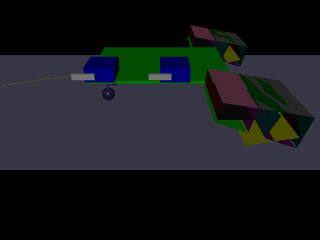

In [458]:
t,x,frames = runXML(ostrich_xml, control=False)